In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt

from _basicClasses import TimeSeriesDatasetSingleSubject, GlobalModel, LocalModel
from _train_pred import predict, evaluate, train, split_dataset
import glob
import pandas as pd
import os

In [2]:
import orjson
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.util import to_pandas


In [3]:
K = 5  # Number of final factors 
# Parameters for the dataset
# J = 5 # Number of subjects
D = 862  # Number of features
# T = 150   # Number of time points
C = 1   # Number of categorical variables
C_levels = 3
num_epochs = 50  # Number of epochs for training
hidden_size_global = 100 
hidden_size_local = 5
train_ratio=.8
batch_size = 32

In [4]:
def create_dataset(csv_directory, target_file_name, target_file_length = 14060):
    # Initialize a list to hold all time series data
    all_series = []

    # Initialize a list to hold the names of the files
    file_names = []

    # List all CSV files in the directory
    csv_files = glob.glob(os.path.join(csv_directory, '*.csv'))

    for file_path in csv_files:
        # print(file_path) 
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Assuming 'traffic_volume' is the column with your time series data
        series = df['traffic_volume'].values
        
        # Convert the series to a PyTorch tensor and add a dimension to make it (T, 1)
        tensor_series = torch.tensor(series, dtype=torch.float32).unsqueeze(1)
        
        # Append the tensor to the list
        if tensor_series.shape[0] == target_file_length:
            all_series.append(tensor_series)
            file_names.append(os.path.basename(file_path).split('.')[0])

    # Concatenate all series along the first dimension to create a (T, D) tensor
    X = torch.cat(all_series, dim=1)

    # X is now a tensor of shape (T, D) where T is the total length of all series combined and D=1
    print("X shape:", X.shape)
    target_index = file_names.index(target_file_name)
    print("target_index:", target_index)
    Y = X[:,target_index]
    print("Y shape and the last 24 time points:", Y.shape, Y[-24:])
    binary_events =  torch.zeros(14060)
    cat_vars = torch.zeros(14060, 1)
    dataset = TimeSeriesDatasetSingleSubject(X, Y, cat_vars, binary_events, input_window_size= 24, output_window_size=24)
    return dataset


In [5]:
test_dataset = create_dataset('./traffic_test_data_files/', 'traffic_test_data_0')

X shape: torch.Size([14060, 862])
target_index: 604
Y shape and the last 24 time points: torch.Size([14060]) tensor([0.0393, 0.0187, 0.0048, 0.0112, 0.0150, 0.0137, 0.0177, 0.0260, 0.0468,
        0.0666, 0.0815, 0.0627, 0.0616, 0.0641, 0.0600, 0.0650, 0.0643, 0.0599,
        0.0577, 0.0562, 0.0560, 0.0467, 0.0412, 0.0386])


In [6]:
train_dataset = create_dataset('./traffic_data_files/', 'traffic_data_0', target_file_length=14036)

X shape: torch.Size([14036, 862])
target_index: 599
Y shape and the last 24 time points: torch.Size([14036]) tensor([0.0427, 0.0322, 0.0266, 0.0218, 0.0166, 0.0178, 0.0180, 0.0194, 0.0192,
        0.0235, 0.0311, 0.0366, 0.0485, 0.0551, 0.0607, 0.0623, 0.0625, 0.0610,
        0.0592, 0.0575, 0.0604, 0.0530, 0.0533, 0.0500])


In [7]:

# train_dataset, test_dataset = split_dataset(dataset, r=0.4, input_window_size=24, output_window_size=24)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [8]:
# Assuming the model instances are created like this:
global_model = GlobalModel(D, hidden_size_global, K, output_window_size=24)

# 1 + num_categorical_features: 
local_model = LocalModel(1 + C, hidden_size_local, output_window_size=24)

optimizer = torch.optim.Adam(list(global_model.parameters()) + list(local_model.parameters()), lr=0.001)


In [9]:

# # For early stopping
# patience = 10
# min_loss = float('inf')
# best_model = None
# best_epoch = 0

for epoch in range(num_epochs):
    torch.manual_seed(1)
    train_loss = train(global_model, local_model, optimizer, train_dataloader)
    # test_loss = evaluate(global_model, local_model, test_dataloader)
    # print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')


Epoch 1, Train Loss: -0.0591
Epoch 2, Train Loss: -1.5463
Epoch 3, Train Loss: -1.7604
Epoch 4, Train Loss: -1.8711
Epoch 5, Train Loss: -1.9660
Epoch 6, Train Loss: -2.0562
Epoch 7, Train Loss: -2.1466
Epoch 8, Train Loss: -2.2422
Epoch 9, Train Loss: -2.3038
Epoch 10, Train Loss: -2.3823
Epoch 11, Train Loss: -2.4652
Epoch 12, Train Loss: -2.4930
Epoch 13, Train Loss: -2.5210
Epoch 14, Train Loss: -2.5720
Epoch 15, Train Loss: -2.5887
Epoch 16, Train Loss: -2.6102
Epoch 17, Train Loss: -2.6439
Epoch 18, Train Loss: -2.6907
Epoch 19, Train Loss: -2.6982
Epoch 20, Train Loss: -2.7211
Epoch 21, Train Loss: -2.6968
Epoch 22, Train Loss: -2.7297
Epoch 23, Train Loss: -2.7661
Epoch 24, Train Loss: -2.7552
Epoch 25, Train Loss: -2.7861
Epoch 26, Train Loss: -2.7819
Epoch 27, Train Loss: -2.7964
Epoch 28, Train Loss: -2.7849
Epoch 29, Train Loss: -2.8632
Epoch 30, Train Loss: -2.8832
Epoch 31, Train Loss: -2.8397
Epoch 32, Train Loss: -2.8809
Epoch 33, Train Loss: -2.8737
Epoch 34, Train Los

In [10]:
W = (global_model).get_weight_matrix()
print(W)

Parameter containing:
tensor([ 1.1580e-03,  1.5038e-03, -9.8480e-01,  1.9305e-01,  2.1458e-04],
       requires_grad=True)


In [11]:

# Assuming you've already loaded your test DataLoader: test_dataloader
mus, sigmas, p_collected, z_collected, true_values, binary_events  = predict(global_model, local_model, test_dataloader)

# Convert to numpy for easier handling
mus_np = mus.numpy()
sigmas_np = sigmas.numpy()
p_collected = p_collected.numpy()
z_collected = z_collected.numpy()

true_values_np = true_values.numpy()
binary_events_np = binary_events.numpy()



In [12]:
# print(mus.shape, mus)
# print(sigmas.shape, sigmas)
# print(p_collected.shape, p_collected)
print(true_values[-2])
print(true_values[-1])
# print(binary_events_np)
# print(p_collected[:,0])

tensor([0.0500, 0.0393, 0.0187, 0.0048, 0.0112, 0.0150, 0.0137, 0.0177, 0.0260,
        0.0468, 0.0666, 0.0815, 0.0627, 0.0616, 0.0641, 0.0600, 0.0650, 0.0643,
        0.0599, 0.0577, 0.0562, 0.0560, 0.0467, 0.0412])
tensor([0.0393, 0.0187, 0.0048, 0.0112, 0.0150, 0.0137, 0.0177, 0.0260, 0.0468,
        0.0666, 0.0815, 0.0627, 0.0616, 0.0641, 0.0600, 0.0650, 0.0643, 0.0599,
        0.0577, 0.0562, 0.0560, 0.0467, 0.0412, 0.0386])


In [13]:
len(mus_np[-1])

24

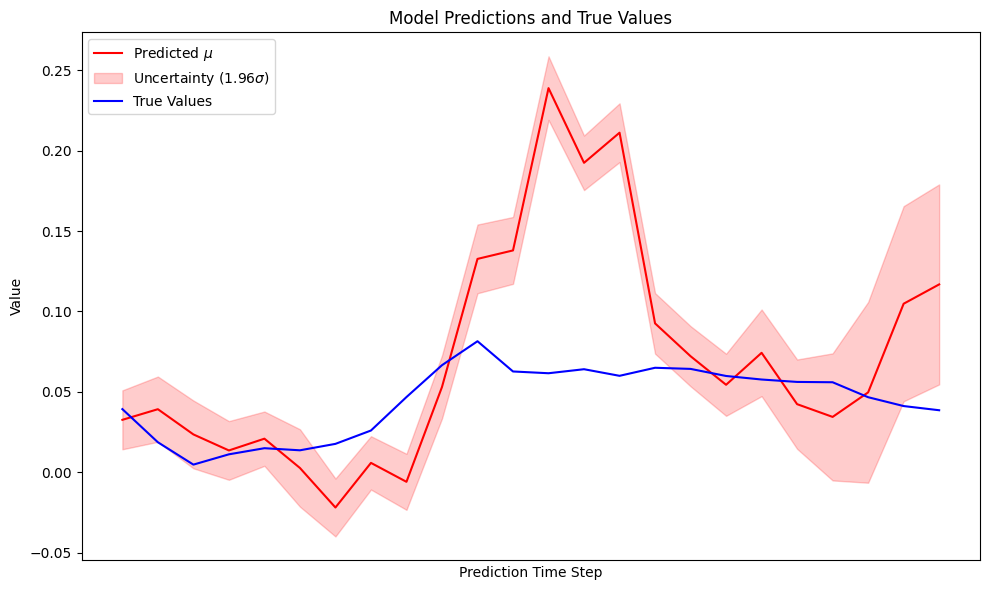

In [15]:
mus_subject = z_collected[-1]
sigmas_subject = sigmas_np[-1]
true_values_subject = true_values_np[-1]
binary_events_subject = binary_events_np[-1]
p_subject = p_collected[-1] # Extracted probabilities


plt.figure(figsize=(10, 6))
plt.plot(mus_subject, label='Predicted $\mu$', color='red')
plt.fill_between(range(len(mus_subject)), (mus_subject - 1.96 * sigmas_subject), (mus_subject + 1.96 * sigmas_subject), color='red', alpha=0.2, label='Uncertainty ($1.96\sigma$)')
plt.plot(true_values_subject, label='True Values', color='blue')

# Plotting the probability as a bar plot at the bottom
bar_height = p_subject  # Scaling factor for visibility
bar_bottom = np.min(true_values_subject)    # Adjust bottom to avoid overlap
# plt.bar(range(len(p_subject)), bar_height,  bottom=bar_bottom, color='gray', label='Event Pred. Probability', width=0.8)

# for i, (value, event) in enumerate(zip(true_values_subject, binary_events_subject)):
#     if event == 1:
#         plt.plot(i, value, 'x', color='black', markersize=8, label='Event = 1' if i == 0 else "")

plt.xticks(range(len(binary_events_subject)))
plt.xlabel('Prediction Time Step')
plt.ylabel('Value')
plt.title('Model Predictions and True Values')
plt.xticks([])

# plt.axhline(y=threshold, color='gray', linestyle='--', linewidth=1, label='Threshold')
# Adjust y-axis limit to make space for the bar plot
# plt.ylim([np.min(bar_bottom)-.5, np.max(true_values_subject) + 1.2])
# plt.xlim([0,1000])
# Legend
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure unique labels
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()
